# Gillespie algorithm to generate the LD distribution

In [6]:
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt

class MutationSimulation:
    def __init__(self, total_time=1440, num_simulations=10000):
        self.t_tot = total_time  # Total simulation time (24 hours in minutes)
        self.num_simulations = num_simulations  # Number of simulation runs
        self.mutationbins = []  # List to store final mutation counts
        self.Ns = []  # List to store final population counts
        self.matrix = np.zeros((24, self.num_simulations))  # Matrix to store hourly mutation counts for each run
    
    @staticmethod
    @jit(nopython=True)
    def LD_time(t_tot, m):
        l = np.log(2) / 120  # Decay rate constant
        mu = 5e-5  # Mutation rate
        n = 1000  # Initial population
        t = 0  # Initial time
        last_recorded_hour = -1  # Initialize the last recorded hour
        ms = []  # List to store m values at each hour

        while t < t_tot:
            # Define rates
            s1 = l * (n - m)
            s2 = l * m
            s3 = l * mu * (n - m)
            S = s1 + s2 + s3

            # Generate random values
            r1 = np.random.uniform(0, 1)
            r2 = np.random.uniform(0, 1)

            # Calculate time step
            delta_t = -np.log(r1) / S

            # Update population and mutation values
            if r2 <= s1 / S:
                n += 1
            elif r2 <= (s1 + s2) / S:
                m += 1
            elif r2 < 1:
                m += 1

            # Calculate the current hour
            current_hour = int(t / 60)

            # Record m value if a new hour has passed
            if current_hour > last_recorded_hour:
                ms.append(m)
                last_recorded_hour = current_hour  # Update the last recorded hour

            # Update time
            t += delta_t

        return n, m, t, ms

    def run_simulation(self):
        """
        Run the mutation simulation for the specified number of simulations.
        Store results in the mutationbins, Ns, and matrix attributes.
        """
        for i in tqdm(range(self.num_simulations)):
            n, m, t, array = self.LD_time(self.t_tot, 0)  # Zero mutants initially
            self.Ns.append(n)
            self.matrix[:, i] = np.array(array[:24])  # Store hourly mutation counts (max 24 hours)
            self.mutationbins.append(m)

    def get_results(self):
        """ Return the stored simulation results: Ns, mutationbins, and matrix. """
        return self.Ns, self.mutationbins, self.matrix


In [2]:
if __name__ == "__main__":
    simulation = MutationSimulation(total_time=1440, num_simulations=5000)
    simulation.run_simulation()
    Ns, mutationbins, matrix = simulation.get_results()

100%|██████████| 5000/5000 [04:22<00:00, 19.02it/s]


In [4]:
means = np.mean(matrix,axis=1)
var = np.var(matrix,axis=1)


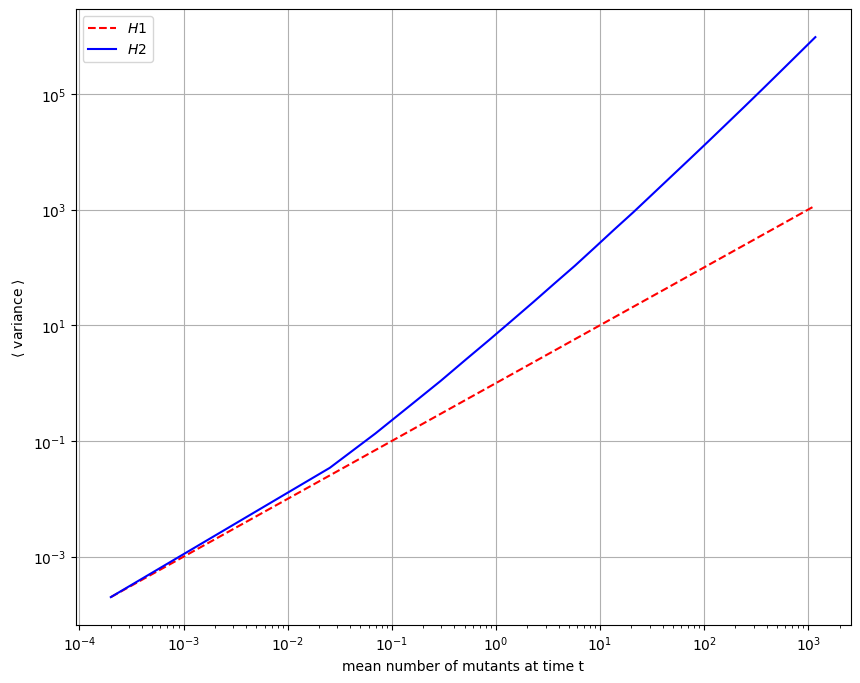

In [8]:
plt.figure(figsize=(10,8))
plt.loglog(means,means,'--',color='r',label=r'$H1$')
plt.loglog(means,var,color='b',label=r'$H2$')
plt.xlabel('mean number of mutants at time t')
plt.ylabel(r'$\langle$ variance $\rangle$')
plt.legend()
plt.grid()

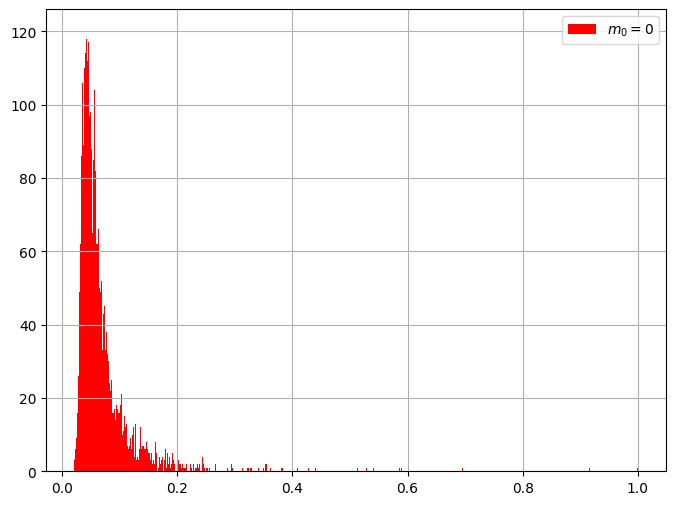

In [9]:
mutationbins = np.array(mutationbins)
plt.figure(figsize=(8,6))
n1,bins,patches = plt.hist(mutationbins/max(mutationbins),bins=1000,density=False,color='r',label=r'$m_0 = 0$')
#n2,bins,patches = plt.hist(mutationbinsfinite/max(mutationbinsfinite),bins=1000,density=False,color='g',label=r'$m_0 = 100$')
plt.legend()
plt.grid()

# Maximum Likelihood Estimation (MLE)

In [10]:
@jit(nopython=True)
def MLE(Nmax, mu, array):
    """
    Maximum Likelihood Estimation (MLE) for mutation rates.
    
    Parameters:
    Nmax: int - Maximum population size
    mu: float - Mutation rate
    array: numpy array - Array of observed mutation counts
    
    Returns:
    s: float - Log likelihood value
    """
    # Calculate the probability of zero mutations
    p_0 = np.exp(-mu * Nmax)
    
    # Maximum observed mutation count
    m_max = int(max(array))
    
    # Initialize probabilities array
    probs = np.zeros((m_max + 1))
    probs[0] = p_0
    
    # Compute probabilities for mutation counts
    for m in range(1, m_max + 1):
        if m == 1:
            probs[m] = probs[0] / 2  # Special case for m=1
        else:
            # Calculate the sum of probabilities for previous mutation counts
            for j in range(m):
                probs[m] += probs[j] / (m - j + 1)
                
        # Adjust the probability with mutation rate
        probs[m] = probs[m] * (mu * Nmax / m)
    
    # Calculate the log likelihood
    s = 0
    for i in range(len(array)):
        s += np.log(probs[int(array[i])])
    
    return s


In [11]:
MLEs = []
mutation_rates = np.arange(1e-6,1e-4,1e-6)

In [12]:
# Convert mutationbins to a numpy array if it's not already
mutationbins_np = np.array(mutationbins)

# Pre-allocate the MLEs array for efficiency
MLEs = np.zeros(len(mutation_rates))

# Use tqdm for progress tracking and calculate MLEs
for i, mu in enumerate(tqdm(mutation_rates)):
    MLEs[i] = MLE(4088983, mu, mutationbins_np)


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


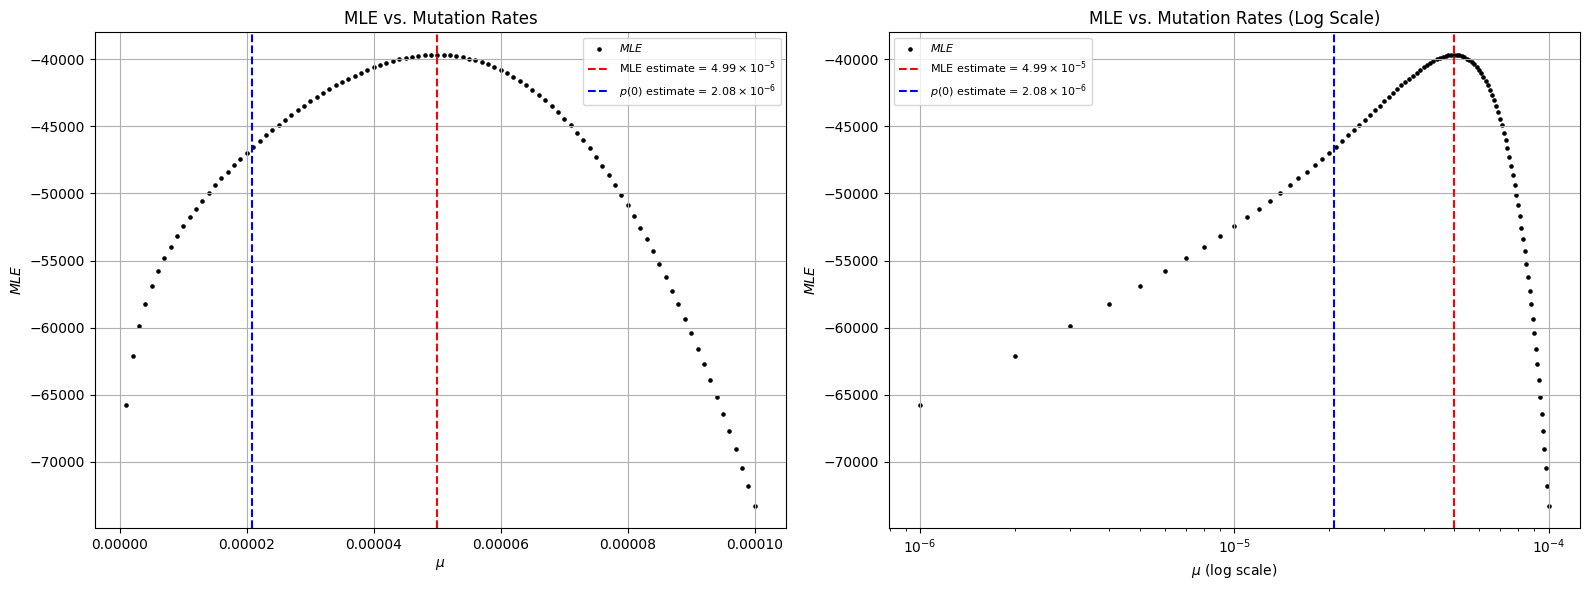

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Regular scatter plot
axes[0].scatter(mutation_rates, MLEs, color='black', s=5.2, label='$MLE$')
axes[0].set_ylabel(r'$MLE$')
axes[0].set_xlabel(r'$\mu$')
axes[0].axvline(x=4.9999999999999996e-05, color='red', linestyle='--', label=r'MLE estimate = $4.99 \times 10^{-5}$')
axes[0].axvline(x=2.0829612623520905e-05, color='blue', linestyle='--', label=r'$p(0)$ estimate = $2.08 \times 10^{-6}$')
axes[0].legend(fontsize=8)
axes[0].grid()
axes[0].set_title("MLE vs. Mutation Rates")

# Logarithmic scatter plot on the x-axis
axes[1].scatter(mutation_rates, MLEs, color='black', s=5.2, label='$MLE$')
axes[1].set_ylabel(r'$MLE$')
axes[1].set_xlabel(r'$\mu$ (log scale)')
axes[1].axvline(x=4.9999999999999996e-05, color='red', linestyle='--', label=r'MLE estimate = $4.99 \times 10^{-5}$')
axes[1].axvline(x=2.0829612623520905e-05, color='blue', linestyle='--', label=r'$p(0)$ estimate = $2.08 \times 10^{-6}$')
axes[1].legend(fontsize=8)
axes[1].set_xscale('log')  # Logarithmic scale for x-axis
axes[1].grid()
axes[1].set_title("MLE vs. Mutation Rates (Log Scale)")

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

